<a href="https://colab.research.google.com/github/Kwonjihan/ML-teamproject/blob/develop/JoohyunKwon/rf_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab Notebooks/6000_IMDB_Dataset.csv'

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
df = pd.read_csv(path)
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


In [3]:
reviews=list(df['review'])
sentiments=list(df['sentiment'])

In [4]:
from sklearn.model_selection import train_test_split
X =np.array(reviews)
y=np.array(sentiments)

#X_train, X_eval, y_train, y_eval=train_test_split(X, y, test_size=0.2)

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec=TfidfVectorizer(min_df=0.0, analyzer="char", sublinear_tf=True, ngram_range=(1,3), max_features=5000)
X_train_tfidf_vec = tfidf_vec.fit_transform(X)


In [6]:
X_train_tfidf_vec

<6000x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 5572924 stored elements in Compressed Sparse Row format>

In [7]:
X_train, X_eval, y_train, y_eval=train_test_split(X_train_tfidf_vec, y, test_size=0.2)

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
# 랜덤 포레스트 분류기에 100개의 의사결정 트리를 사용한다.
forest=RandomForestClassifier(n_estimators=100)
score=cross_val_score(forest, X_train, y_train, cv=5)
# 단어 묶음을 벡터화한 데이터와 정답 데이터를 가지고 학습을 시작한다.
forest.fit(X_train,y_train)

RandomForestClassifier()

In [9]:
print(f"cross validation score : {score.mean()}")

cross validation score : 0.7795833333333333


In [10]:
print("Accuracy: %f" % forest.score(X_eval,y_eval))


Accuracy: 0.764167


In [11]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators':[10,50,100],
    'criterion':['gini','entropy'],
    'max_depth':[5,10,15],
    'min_samples_split':[2,3,5],
    'min_samples_leaf':[1,2,3],
    'max_features':['sqrt','log2'],
    'bootstrap':[True,False]
}

In [13]:
clf = RandomForestClassifier(random_state=42) # 과제를 위해 random_state를 고정해두었습니다.
gs = GridSearchCV(estimator=clf,param_grid=param_grid,scoring='accuracy',cv=5)#gridsearch로 clf에서 하이퍼 파라미터 탐색
gs=gs.fit(X_train,y_train)

best_parameters =gs.best_params_ #하이퍼 파라미터 반환
best_score =gs.best_score_ #best hyperparameter로 train했을때 accuracy
print(f"Best parameters: {best_parameters}")
print(f"Best score: {best_score}")

Best parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best score: 0.7891666666666666


In [14]:
from sklearn.metrics import accuracy_score

best_model = RandomForestClassifier(n_estimators=best_parameters['n_estimators'],   #위에서 구한 파라미터로 다시 세팅
                                    criterion=best_parameters['criterion'],
                                    max_depth=best_parameters['max_depth'],
                                    min_samples_split=best_parameters['min_samples_split'],
                                    min_samples_leaf=best_parameters['min_samples_leaf'],
                                    max_features=best_parameters['max_features'],
                                    bootstrap=best_parameters['bootstrap'],)
best_model.fit(X_train,y_train) #학습

y_pred = best_model.predict(X_eval)
best_accuracy = accuracy_score(y_eval, y_pred)

print(f'Best Model 정확도: {best_accuracy:.4f}')

Best Model 정확도: 0.7825


Text(0.5, -0.15, 'F1 Score: 0.7771 Precision: 0.7778 Recall: 0.7765')

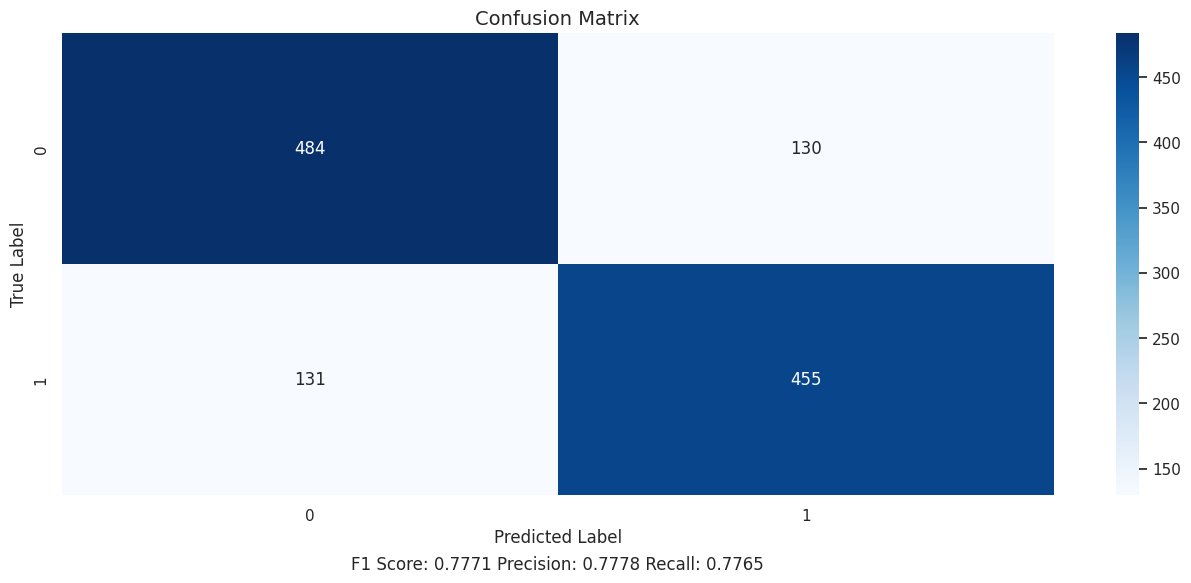

In [18]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
cm1 =confusion_matrix(y_eval,y_pred) #confusin matrix
f1_1 =f1_score(y_eval,y_pred,pos_label='positive') #f1score
precision_1 =precision_score(y_eval,y_pred,pos_label='positive')#precision
recall_1 =recall_score(y_eval,y_pred,pos_label='positive')#recall
fig, axes = plt.subplots(figsize=(16, 6))

# 첫 번째 subplot: baseline model
sns.heatmap(cm1, annot=True, cmap='Blues', fmt='d', ax=axes) #cm1 시각화
axes.set_title('Confusion Matrix', fontsize=14)
axes.set_xlabel('Predicted Label', fontsize=12)
axes.set_ylabel('True Label', fontsize=12)
axes.text(0.5, -0.15, f'F1 Score: {f1_1:.4f} Precision: {precision_1:.4f} Recall: {recall_1:.4f}',
             horizontalalignment='center', verticalalignment='center', transform=axes.transAxes,fontsize=12)

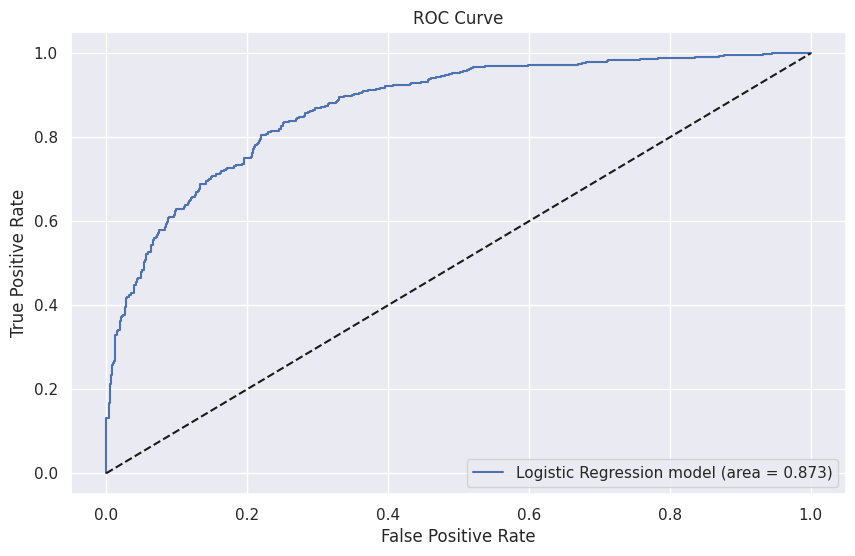

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score

lr_proba = best_model.predict_proba(X_eval)[:, 1]#baseline의 예측확률을 계산
fp_lr, tp_lr,_ = roc_curve(y_eval, lr_proba,pos_label='positive')#roc curve를 계산
auroc_baseline = roc_auc_score(y_eval, lr_proba)#auroc를 계산

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(fp_lr, tp_lr, label=f'Logistic Regression model (area = {auroc_baseline:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()